In [58]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np
import os

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.metrics import accuracy_score
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
wd = os.getcwd()

# Load dataset
df = pd.read_csv(os.path.join("C:\\Users\\Louisa\\Downloads", "diabetes.csv"))
display(df.info(), df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# 2 datasets
D = df[(df['Outcome'] != 0)]
H = df[(df['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = df['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=df['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = df['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)


In [4]:
target_count()
target_percent()

In [5]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    



In [6]:
# Call the function with the dataset name and the key column
missing_plot(df, 'Outcome')

In [7]:
def correlation_plot():
    #correlation
    correlation = df.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                        )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)


In [8]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
Glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
BloodPressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
SkinThickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
Insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
BMI,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
DiabetesPedigreeFunction,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
Age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
Outcome,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


In [9]:
correlation_plot()

In [10]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp


In [11]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [12]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = 102.5
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = 169.5


In [13]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [14]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = 140


In [15]:
median_target('SkinThickness')


,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [16]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32


In [17]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [18]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 74.5


In [19]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [20]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = 30.1
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = 34.3


In [21]:
missing_plot(df, 'Outcome')

In [22]:
def plot_feat1_feat2(feat1, feat2) :  
    D = df[(df['Outcome'] != 0)]
    H = df[(df['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
   xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)


In [23]:
def barplot(var_select, sub) :
    tmp1 = df[(df['Outcome'] != 0)]
    tmp2 = df[(df['Outcome'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(df[var_select],df['Outcome']), )
    tmp3['% diabetic'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='diabetic',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='healthy', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['% diabetic'],
        yaxis = 'y2',
        name='% diabetic', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% diabetic'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)


In [24]:
 # Define pie plot to visualize each variable repartition vs target modalities : Survived or Died (train)
def plot_pie(var_select, sub) :
    D = df[(df['Outcome'] != 0)]
    H = df[(df['Outcome'] == 0)]

    col =['Silver', 'mediumturquoise','#CF5C36','lightblue','magenta', '#FF5D73','#F2D7EE','mediumturquoise']

    trace1 = go.Pie(values  = D[var_select].value_counts().values.tolist(),
                    labels  = D[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Diabetic",
                    marker  = dict(colors = col, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = H[var_select].value_counts().values.tolist(),
                    labels  = H[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Healthy" )

    layout = go.Layout(dict(title = var_select + " distribution by target <br>"+(sub),
          annotations = [ dict(text = "Diabetic"+" : "+str(D[var_select].value_counts()[1]),
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "Healthy"+" : "+str(H[var_select].value_counts()[1]),
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)


In [25]:
plot_feat1_feat2('Glucose','Age')

In [26]:
plot_feat1_feat2('Pregnancies','Age')

In [27]:
plot_feat1_feat2('Glucose','BloodPressure')

In [28]:

X = df.drop('Outcome', axis = 1)
y = df['Outcome']
# print(X.shape)
print(X)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0    102.5  36.8   
765            5    121.0           72.0           23.0    112.0  26.2   
766            1    126.0           60.0           32.0    169.5  30.1   
767            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  


In [29]:
# Data preprocessing
# Replace 0 values with the mean
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean())
df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].mean())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].mean())
df['BMI'] = df['BMI'].replace(0, df['BMI'].mean())

In [30]:
# Separate the features and target variable
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [31]:
# Balanced data
X, y = resample(X, y, stratify=y, random_state=42)

In [32]:
# Data preprocessing (continued)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [33]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=5)
X = selector.fit_transform(X, y)

In [34]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [35]:
#creating the models
svc = SVC(C=1, kernel='rbf')
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
lgbm = LGBMClassifier(max_depth=3, num_leaves=15)



In [36]:
#hyperparameter tuning
param_grid_svc = {'C' : [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
param_grid_lgbm = {'max_depth':[3, 5, 7], 'num_leaves':[7, 15, 31]}
param_grid_knn = {'n_neighbors': range(1,21)}

In [37]:
#cross validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)



In [38]:
#grid search
grid_svc = GridSearchCV(svc, param_grid_svc, cv=skf, scoring='accuracy', n_jobs=-1)
grid_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=skf, scoring='accuracy', n_jobs=-1)
grid_knn = GridSearchCV(knn, param_grid_knn, cv=skf, scoring='accuracy', n_jobs=-1)

In [39]:
#fitting the models
grid_svc.fit(X_train, y_train)
grid_lgbm.fit(X_train, y_train)
grid_knn.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(n_neighbors=10, weights='distance'),
             n_jobs=-1, param_grid={'n_neighbors': range(1, 21)},
             scoring='accuracy')

In [40]:
#printing the best parameters
print("Best parameters for SVC: {}".format(grid_svc.best_params_))
print("Best parameters for LGBM: {}".format(grid_lgbm.best_params_))
print("Best parameters for KNN: {}".format(grid_knn.best_params_))


Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best parameters for LGBM: {'max_depth': 7, 'num_leaves': 15}
Best parameters for KNN: {'n_neighbors': 10}


In [41]:
#creating the ensemble
estimators = [('SVC', grid_svc.best_estimator_), ('KNN', grid_knn.best_estimator_), ('LGBM', grid_lgbm.best_estimator_)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV())

In [42]:
#fitting the model
stacking_model.fit(X_train, y_train)



StackingClassifier(estimators=[('SVC', SVC(C=10)),
                               ('KNN',
                                KNeighborsClassifier(n_neighbors=10,
                                                     weights='distance')),
                               ('LGBM',
                                LGBMClassifier(max_depth=7, num_leaves=15))],
                   final_estimator=LogisticRegressionCV())

In [43]:
#predicting the type 2 diabetes
y_pred = stacking_model.predict(X_test)



In [44]:
#printing the accuracy
print("The accuracy of the model is: ", accuracy_score(y_test, y_pred))

The accuracy of the model is:  0.9805194805194806


In [45]:
# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)



F1 score: 0.963855421686747


In [46]:
# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


Precision: 0.975609756097561


In [47]:
# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)



Recall: 0.9523809523809523


In [48]:
# ROC/AUC
probabilities = stacking_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC/AUC:", roc_auc)

ROC/AUC: 0.9808673469387755


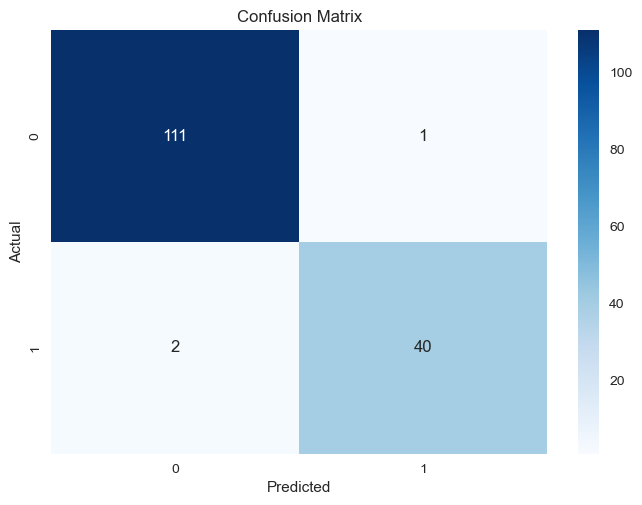

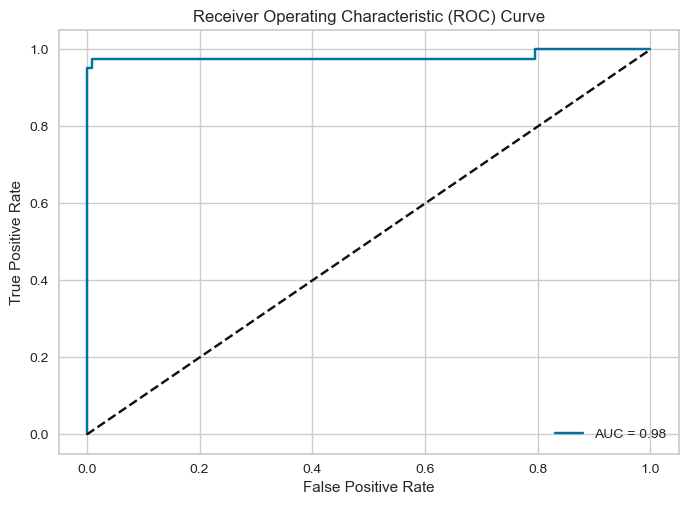

In [49]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [50]:
matrix = classification_report(y_test, y_pred)
print("Classification report: \n", matrix)

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       112
           1       0.98      0.95      0.96        42

    accuracy                           0.98       154
   macro avg       0.98      0.97      0.98       154
weighted avg       0.98      0.98      0.98       154



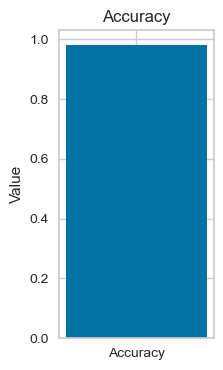

In [78]:


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(2, 4))

# Create a bar chart
ax.bar(["Accuracy"], [accuracy])

# Set the title and labels
ax.set_title("Accuracy")
ax.set_ylabel("Value")

# Show the plot
plt.show()
